In [1]:
%load_ext autoreload
%autoreload 2
from functions import *

In [2]:
data_train = pd.read_excel("./data/lassoed_train_val_test.xlsx", sheet_name="train")
data_val = pd.read_excel("./data/lassoed_train_val_test.xlsx", sheet_name="val")
data_test = pd.read_excel("./data/lassoed_train_val_test.xlsx", sheet_name="test")
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values
X_val = data_val.iloc[:, 1:].values
y_val = data_val.iloc[:, 0].values
X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

In [3]:
# 定义模型
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
}
# 定义置信度
confidences = [0.95, 0.9, 0.8, 0.7, 0.6, 0.5]
# 定义结果存储
coverage_ratios = pd.DataFrame(index=models.keys(), columns=confidences)
useful_coverage_ratios = pd.DataFrame(index=models.keys(), columns=confidences)
coverage_ratios_for_y_equals_1 = pd.DataFrame(index=models.keys(), columns=confidences)
useful_coverage_ratios_for_y_equals_1 = pd.DataFrame(
    index=models.keys(), columns=confidences
)
undecided_ratios = pd.DataFrame(index=models.keys(), columns=confidences)

In [4]:
def get_prediction_set(model, confidence=0.9, err_func=InverseProbabilityErrFunc()):
    # 创建一个 Nonconformity function
    nc = NcFactory.create_nc(model=model, err_func=err_func)
    # 创建一个 inductive conformal classifier
    icp = IcpClassifier(nc)
    # 训练模型
    icp.fit(X_train, y_train)
    # 校准模型
    icp.calibrate(X_val, y_val)
    # 在测试集上进行预测，给出预测标签的集合
    prediction_set = icp.predict(X_test, significance=1 - confidence)
    # 计算 prediction set
    prediction_set = list(
        map(lambda row: tuple(i for i, x in enumerate(row) if x), prediction_set)
    )
    return prediction_set

In [5]:
# 计算每个模型在不同置信度下的 coverage ratio
for model_name, model in tqdm(models.items()):
    for confidence in confidences:
        prediction_set = get_prediction_set(model, confidence)
        coverage_ratios.loc[model_name, confidence] = cal_coverage_ratio(
            prediction_set, y_test
        )
        useful_coverage_ratios.loc[model_name, confidence] = cal_useful_coverage_ratio(
            prediction_set, y_test
        )
        coverage_ratios_for_y_equals_1.loc[
            model_name, confidence
        ] = cal_coverage_ratio_for_y_equals_1(prediction_set, y_test)
        useful_coverage_ratios_for_y_equals_1.loc[
            model_name, confidence
        ] = cal_useful_coverage_ratio_for_y_equals_1(prediction_set, y_test)
        undecided_ratios.loc[
            model_name, confidence
        ] = cal_undecided_ratio(prediction_set, y_test)

100%|██████████| 8/8 [02:25<00:00, 18.24s/it]


In [11]:
# 保存结果
coverage_ratios.to_excel("./results/coverage_ratios.xlsx")
useful_coverage_ratios.to_excel("./results/useful_coverage_ratios.xlsx")
coverage_ratios_for_y_equals_1.to_excel(
    "./results/coverage_ratios_for_y_equals_1.xlsx"
)
useful_coverage_ratios_for_y_equals_1.to_excel(
    "./results/useful_coverage_ratios_for_y_equals_1.xlsx"
)
undecided_ratios.to_excel("./results/undecided_ratios.xlsx")

Coverage Ratio by Confidence

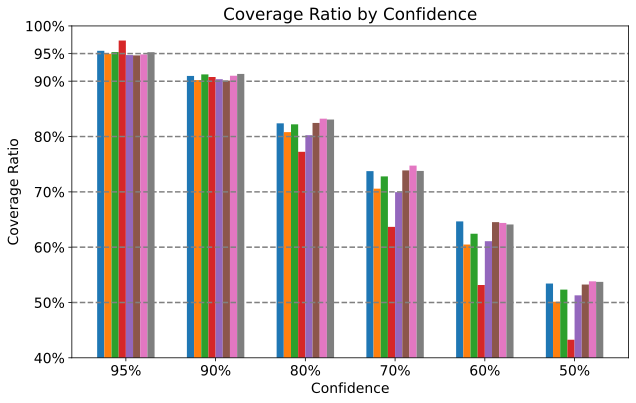

In [17]:
# 设置字体为14，用于图例中显示分类器名称
plt.rcParams["font.size"] = 14
# 设置画布大小
fig = plt.figure(figsize=(10, 6), dpi=300)
# 绘制柱状图
for i, model in enumerate(coverage_ratios.index):
    plt.bar(
        [x + i * 0.08 for x in range(coverage_ratios.shape[1])],
        coverage_ratios.loc[model],
        width=0.08,
        label=model,
    )
# 设置横坐标刻度
plt.xticks(
    [x + 0.28 for x in range(coverage_ratios.shape[1])],
    [f"{confidences[x]*100:.0f}%" for x in range(coverage_ratios.shape[1])],
)
# 设置纵坐标刻度
plt.yticks([x / 10 for x in range(4, 11)] + [0.95])
# 设置纵轴百分比显示格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# 添加置信度的水平线
for confidence in confidences:
    plt.axhline(y=confidence, color="gray", linestyle="--")
# y轴范围
plt.ylim(0.4, 1)
# 添加xy轴标签和标题
plt.xlabel("Confidence")
plt.ylabel("Coverage Ratio")
plt.title("Coverage Ratio by Confidence")
# 添加分类器名称的图例
# plt.legend(loc="upper right")
# 显示图形
plt.show()
# 保存图形
fig.savefig(
    "./results/Coverage Ratio by Confidence.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)

Useful Coverage Ratio by Confidence

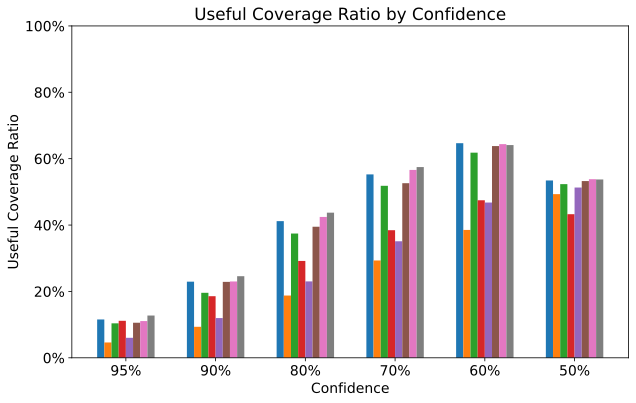

In [18]:
# 设置字体为14，用于图例中显示分类器名称
plt.rcParams["font.size"] = 14
# 设置画布大小
fig = plt.figure(figsize=(10, 6), dpi=300)
# 绘制柱状图
for i, model in enumerate(useful_coverage_ratios.index):
    plt.bar(
        [x + i * 0.08 for x in range(useful_coverage_ratios.shape[1])],
        useful_coverage_ratios.loc[model],
        width=0.08,
        label=model,
    )
# 设置横坐标刻度
plt.xticks(
    [x + 0.28 for x in range(useful_coverage_ratios.shape[1])],
    [f"{confidences[x]*100:.0f}%" for x in range(useful_coverage_ratios.shape[1])],
)
# 设置纵坐标刻度
# plt.yticks([x / 10 for x in range(4, 11)] + [0.95])
# 设置纵轴百分比显示格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# y轴范围
plt.ylim(0, 1)
# 添加xy轴标签和标题
plt.xlabel("Confidence")
plt.ylabel("Useful Coverage Ratio")
plt.title("Useful Coverage Ratio by Confidence")
# 添加分类器名称的图例
# plt.legend(loc="upper left")
# 显示图形
plt.show()
# 保存图形
fig.savefig(
    "./results/Useful Coverage Ratio by Confidence.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)

For y=1: Coverage Ratio by Confidence

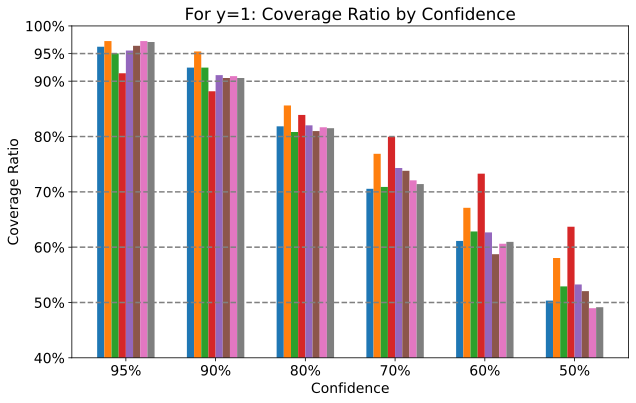

In [19]:
# 设置字体为14，用于图例中显示分类器名称
plt.rcParams["font.size"] = 14
# 设置画布大小
fig = plt.figure(figsize=(10, 6), dpi=300)
# 绘制柱状图
for i, model in enumerate(coverage_ratios_for_y_equals_1.index):
    plt.bar(
        [x + i * 0.08 for x in range(coverage_ratios_for_y_equals_1.shape[1])],
        coverage_ratios_for_y_equals_1.loc[model],
        width=0.08,
        label=model,
    )
# 设置横坐标刻度
plt.xticks(
    [x + 0.28 for x in range(coverage_ratios_for_y_equals_1.shape[1])],
    [f"{confidences[x]*100:.0f}%" for x in range(coverage_ratios_for_y_equals_1.shape[1])],
)
# 设置纵坐标刻度
plt.yticks([x / 10 for x in range(4, 11)] + [0.95])
# 设置纵轴百分比显示格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# 添加置信度的水平线
for confidence in confidences:
    plt.axhline(y=confidence, color="gray", linestyle="--")
# y轴范围
plt.ylim(0.4, 1)
# 添加xy轴标签和标题
plt.xlabel("Confidence")
plt.ylabel("Coverage Ratio")
plt.title("For y=1: Coverage Ratio by Confidence")
# 添加分类器名称的图例
# plt.legend(loc="upper right")
# 显示图形
plt.show()
# 保存图形
fig.savefig(
    "./results/For y=1 Coverage Ratio by Confidence.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)

For y=1: Useful Coverage Ratio by Confidence

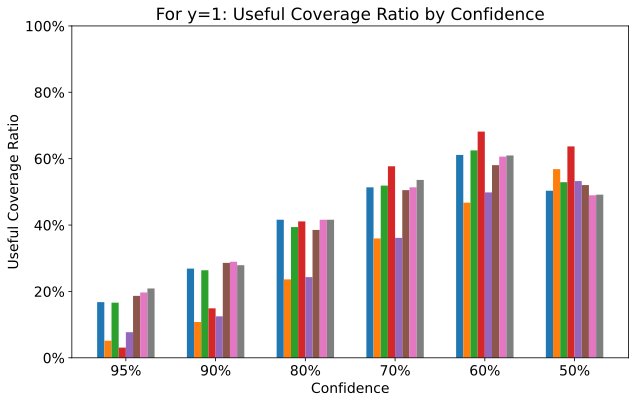

In [20]:
# 设置字体为14，用于图例中显示分类器名称
plt.rcParams["font.size"] = 14
# 设置画布大小
fig = plt.figure(figsize=(10, 6), dpi=300)
# 绘制柱状图
for i, model in enumerate(useful_coverage_ratios_for_y_equals_1.index):
    plt.bar(
        [x + i * 0.08 for x in range(useful_coverage_ratios_for_y_equals_1.shape[1])],
        useful_coverage_ratios_for_y_equals_1.loc[model],
        width=0.08,
        label=model,
    )
# 设置横坐标刻度
plt.xticks(
    [x + 0.28 for x in range(useful_coverage_ratios_for_y_equals_1.shape[1])],
    [f"{confidences[x]*100:.0f}%" for x in range(useful_coverage_ratios_for_y_equals_1.shape[1])],
)
# 设置纵坐标刻度
# plt.yticks([x / 10 for x in range(4, 11)] + [0.95])
# 设置纵轴百分比显示格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# y轴范围
plt.ylim(0, 1)
# 添加xy轴标签和标题
plt.xlabel("Confidence")
plt.ylabel("Useful Coverage Ratio")
plt.title("For y=1: Useful Coverage Ratio by Confidence")
# 添加分类器名称的图例
# plt.legend(loc="upper left")
# 显示图形
plt.show()
# 保存图形
fig.savefig(
    "./results/For y=1 Useful Coverage Ratio by Confidence.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)

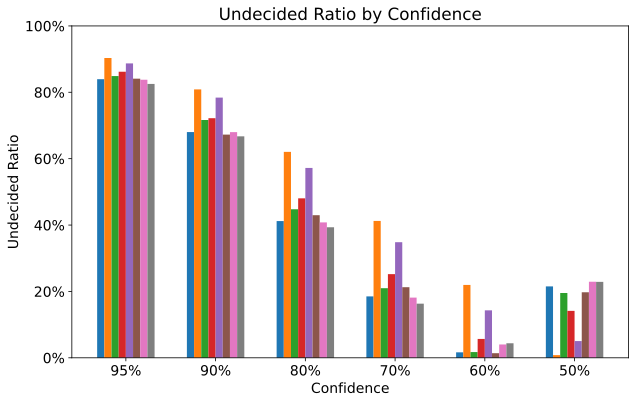

In [21]:
# 设置字体为14，用于图例中显示分类器名称
plt.rcParams["font.size"] = 14
# 设置画布大小
fig = plt.figure(figsize=(10, 6), dpi=300)
# 绘制柱状图
for i, model in enumerate(undecided_ratios.index):
    plt.bar(
        [x + i * 0.08 for x in range(undecided_ratios.shape[1])],
        undecided_ratios.loc[model],
        width=0.08,
        label=model,
    )
# 设置横坐标刻度
plt.xticks(
    [x + 0.28 for x in range(undecided_ratios.shape[1])],
    [f"{confidences[x]*100:.0f}%" for x in range(undecided_ratios.shape[1])],
)
# 设置纵坐标刻度
# plt.yticks([x / 10 for x in range(4, 11)] + [0.95])
# 设置纵轴百分比显示格式
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
# y轴范围
plt.ylim(0, 1)
# 添加xy轴标签和标题
plt.xlabel("Confidence")
plt.ylabel("Undecided Ratio")
plt.title("Undecided Ratio by Confidence")
# 添加分类器名称的图例
# plt.legend(loc="upper right")
# 显示图形
plt.show()
# 保存图形
fig.savefig(
    "./results/Undecided Ratio by Confidence.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)